# Machine Learning

This notebook will address the pre-processing issues I encountered in the last notebook where my test data ended up having different dummy columns in the encoding, causing the model not to fit.

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',None)

In [3]:
# Load data
df_original = pd.read_csv('./Data/train.csv')

# Load the test data too
df_original_test = pd.read_csv('./Data/test.csv')


## Data Exploration

In [4]:
print(df_original.shape)
print(df_original_test.shape)
df_original.head()
df_original.info()

(1460, 81)
(1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null  

In [5]:
df_original.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

Percentage of Rows with NAs in column (df_original):

LotFrontage      17.73% \
Alley            93.76% \
MasVnrType       59.72% \
MasVnrArea        0.54% \
BsmtQual          2.53% \
BsmtCond          2.53% \
BsmtExposure      2.60% \
BsmtFinType1      2.53% \
Electrical        0.06% \
FireplaceQu      47.26% \
GarageType        5.54% \
GarageYrBlt       5.54% \
GarageFinish      5.54% \
GarageQual        5.54% \
GarageCond        5.54% \
PoolQC           99.52% \
Fence            80.75% \
MiscFeature      96.30%

I'm going to impute the values for all NAs, since a linear regression requires all values be present.

In [6]:
# Define column transformations
def fill_na_columns(df):
    # Known transforms
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])

    # For categories, fill with 'None'
    for column in df.select_dtypes(include=['object', 'category']).columns:
        df[column] = df[column].fillna('None')

    # For numerics, fill with median
    for column2 in df.select_dtypes(exclude=['object', 'category']).columns:
        df[column2] = df[column2].fillna(df[column2].median())

    return df

Now that most of the NAs are resolved, I'll split out the target variable and drop other unecessary columns from the analysis.

In [7]:
# Pull out the target variable
y = df_original['SalePrice']

# Drop the target variable so we can combine with the test dataframe
df_original_no_y = df_original.drop(['SalePrice'], axis=1)

# I want to combine the data first for the categorical encodings, and will remove after before fitting
df_orig_comb = pd.concat([df_original_no_y,df_original_test])

print(df_original_no_y.shape)
print(df_orig_comb.shape)

(1460, 80)
(2919, 80)


# Data Preprocessing

In [57]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

df_filled_comb = fill_na_columns(df_orig_comb)

df_filled_combined_categorical = df_filled_comb.select_dtypes(include=['object', 'category'])
df_filled_combined_numeric = df_filled_comb.select_dtypes(exclude=['object', 'category'])

print(df_filled_combined_categorical.shape)
print(df_filled_combined_numeric.shape)


(2919, 43)
(2919, 37)


In [58]:
encoder = OneHotEncoder(sparse=False)
df_encoded = pd.DataFrame(encoder.fit_transform(df_filled_combined_categorical))


c:\Users\rsvag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [84]:
print(df_filled_combined_categorical.shape)
print(df_encoded.shape)

(2919, 43)
(2919, 274)


In [86]:
# Resetting the indices
df_encoded_reset = df_encoded.reset_index(drop=True)
df_numeric_reset = df_filled_combined_numeric.reset_index(drop=True)

# Concatenating the DataFrames
df_recombined = pd.concat([df_encoded_reset, df_numeric_reset], axis=1).reset_index(drop=True)

In [62]:
df_recombined.shape

(2919, 311)

In [63]:
df_recombined_train = df_recombined.iloc[:1460]
df_recombined_test_data = df_recombined.iloc[1460:]

print(df_recombined_train.shape)
print(df_recombined_test_data.shape)

(1460, 311)
(1459, 311)


In [64]:
df_recombined_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0

In [67]:
print(df_recombined_train.isna().sum()[df_recombined_train.isna().sum() > 0])

Series([], dtype: int64)


In [48]:
#from sklearn.pipeline import make_pipeline
#from sklearn.compose import make_column_transformer
#from sklearn.linear_model import LogisticRegression

#column_trans = make_column_transformer(
#    (OneHotEncoder(), ['Sex', 'Embarked']),
#    remainder='passthrough')

#logreg = LogisticRegression(solver='lbfgs')
#pipe = make_pipeline(column_trans, logreg)

Now that the data is cleaned up, time to make some models.

## Data Splitting

In [68]:
X = df_recombined_train.copy()

# Drop Id
X = X.drop(['Id'], axis=1)
X.columns = X.columns.astype(str)

print(X.shape, y.shape)

(1460, 310) (1460,)


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [70]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 310) (292, 310) (1168,) (292,)


In [71]:
y_test.head()

280     228500
1365    216000
132     150750
357     134000
438      90350
Name: SalePrice, dtype: int64

In [18]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

# Use the model to make predictions

In [73]:
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)

lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

print('LR MSE (Train): ', lr_train_mse)
print('LR R2 (Train): ', lr_train_r2)
print('LR MSE (Test): ', lr_test_mse)
print('LR R2 (Test): ', lr_test_r2)

LR MSE (Train):  393925137.7507794
LR R2 (Train):  0.9393536743324402
LR MSE (Test):  232320577949338.53
LR R2 (Test):  -41843.38489815955


In [74]:
lr_results = pd.DataFrame(['Linear Regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

lr_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear Regression,393925137.750779,0.939354,232320577949338.53125,-41843.384898


# Random Forest

In [75]:
rf = RandomForestRegressor(max_depth=12, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=12, random_state=42)

In [76]:
y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

In [77]:
rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

rf_results = pd.DataFrame(['Random Forest', rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

rf_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Random Forest,136157666.337982,0.979038,633950785.649033,0.885816


# Compare models

In [78]:
df_model = pd.concat([lr_results, rf_results], axis=0).reset_index(drop=True)
df_model

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear Regression,393925137.750779,0.939354,232320577949338.53125,-41843.384898
1,Random Forest,136157666.337982,0.979038,633950785.649033,0.885816


# Visualize

Text(0.5, 0, 'Actual Sale Price')

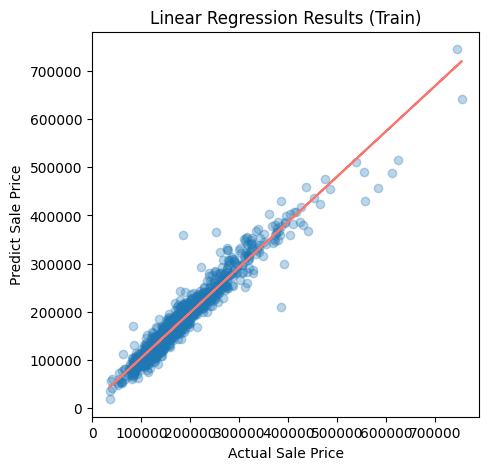

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(x=y_train, y=y_lr_train_pred, alpha=0.3)

z = np.polyfit(y_train, y_lr_train_pred, 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_train), '#F8766d')
plt.title('Linear Regression Results (Train)')
plt.ylabel('Predict Sale Price')
plt.xlabel('Actual Sale Price')

Text(0.5, 0, 'Actual Sale Price')

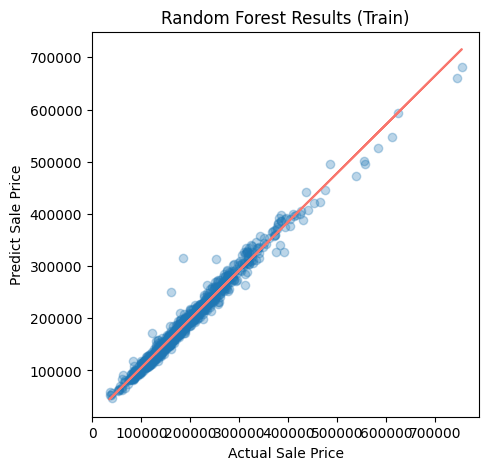

In [80]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_train, y=y_rf_train_pred, alpha=0.3)

z = np.polyfit(y_train, y_rf_train_pred, 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_train), '#F8766d')
plt.title('Random Forest Results (Train)')
plt.ylabel('Predict Sale Price')
plt.xlabel('Actual Sale Price')

It looks like the linear regression does better on the training sets, but random forest should do better on the test data.

Text(0.5, 0, 'Actual Sale Price')

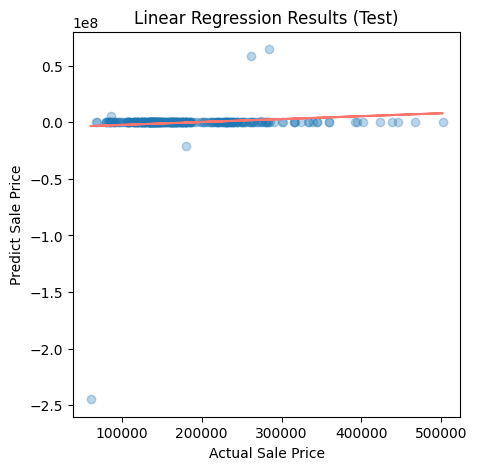

In [81]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_test, y=y_lr_test_pred, alpha=0.3)

z = np.polyfit(y_test, y_lr_test_pred, 1)
p = np.poly1d(z)

plt.plot(y_test, p(y_test), '#F8766d')
plt.title('Linear Regression Results (Test)')
plt.ylabel('Predict Sale Price')
plt.xlabel('Actual Sale Price')

Text(0.5, 0, 'Actual Sale Price')

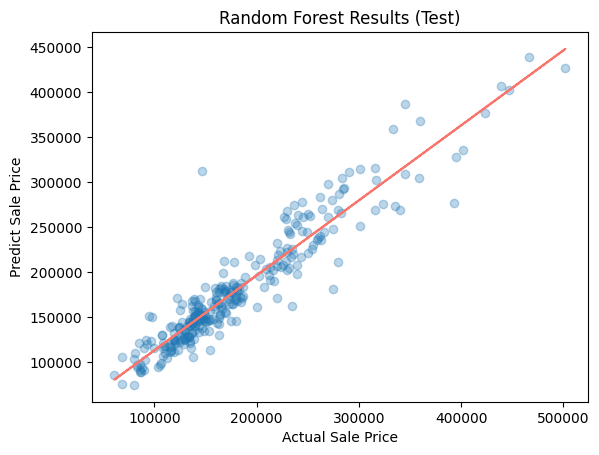

In [83]:
plt.scatter(x=y_test, y=y_rf_test_pred, alpha=0.3)

z = np.polyfit(y_test, y_rf_test_pred, 1)
p = np.poly1d(z)

plt.plot(y_test, p(y_test), '#F8766d')
plt.title('Random Forest Results (Test)')
plt.ylabel('Predict Sale Price')
plt.xlabel('Actual Sale Price')

These models look better than before. Especially the Random Forest. I think it was important to increase that max depth. I could use a GridSearch to make it a little better

In [87]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a base model
rf_gs = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_gs, param_grid=param_grid, cv=3, refit='r2')

# Fit the grid search to the data (replace 'X_train' and 'y_train' with your data)
grid_search.fit(X_train, y_train)

c:\Users\rsvag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rsvag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rsvag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\rsvag\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             refit='r2')

Now lets look for the best params and best score

In [88]:
print('Best Params: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)
print('Best Est: ', grid_search.best_estimator_)

Best Params:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score:  0.8307322371427506
Best Est:  RandomForestRegressor(max_depth=20, max_features='sqrt')


Now lets create a Random Forest Regressor with the best params

In [97]:
rf_optimal = RandomForestRegressor(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)
rf_optimal.fit(X_train,y_train)

y_rf_optimal_train_pred = rf_optimal.predict(X_train)
y_rf_optimal_test_pred = rf_optimal.predict(X_test)

rf_optimal_train_mse = mean_squared_error(y_train, y_rf_optimal_train_pred)
rf_optimal_train_r2 = r2_score(y_train, y_rf_optimal_train_pred)

rf_optimal_test_mse = mean_squared_error(y_test, y_rf_optimal_test_pred)
rf_optimal_test_r2 = r2_score(y_test, y_rf_optimal_test_pred)

rf_optimal_results = pd.DataFrame(['Random Forest Optimal', rf_optimal_train_mse, rf_optimal_train_r2, rf_optimal_test_mse, rf_optimal_test_r2]).transpose()
rf_optimal_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

rf_optimal_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Random Forest Optimal,135712895.152004,0.979106,706584201.632972,0.872734


In [99]:
df_model = pd.concat([df_model[:2], rf_optimal_results], axis=0).reset_index(drop=True)
df_model

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear Regression,393925137.750779,0.939354,232320577949338.53125,-41843.384898
1,Random Forest,136157666.337982,0.979038,633950785.649033,0.885816
2,Random Forest Optimal,135712895.152004,0.979106,706584201.632972,0.872734


# Visualize

Text(0.5, 0, 'Actual Sale Price')

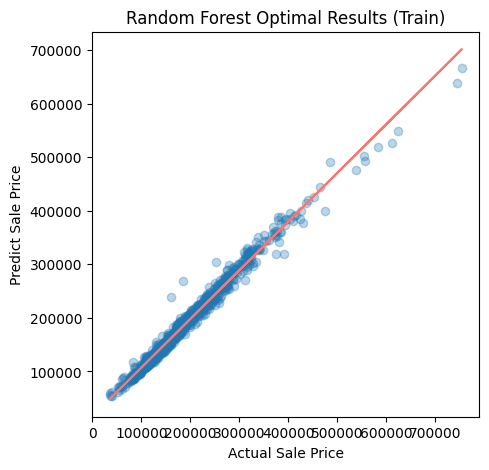

In [100]:
plt.figure(figsize=(5,5))
plt.scatter(x=y_train, y=y_rf_optimal_train_pred, alpha=0.3)

z = np.polyfit(y_train, y_rf_optimal_train_pred, 1)
p = np.poly1d(z)

plt.plot(y_train, p(y_train), '#F8766d')
plt.title('Random Forest Optimal Results (Train)')
plt.ylabel('Predict Sale Price')
plt.xlabel('Actual Sale Price')

Text(0.5, 0, 'Actual Sale Price')

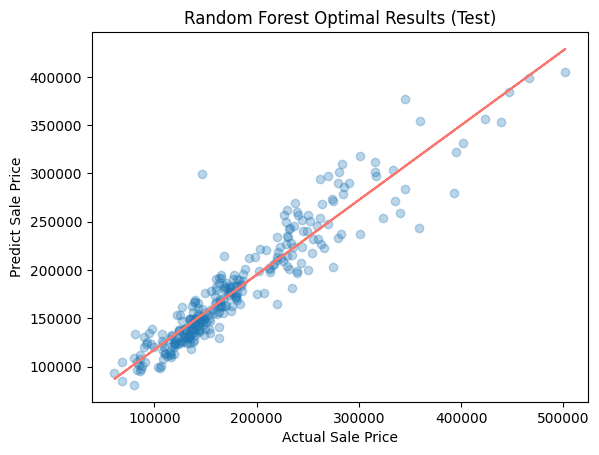

In [101]:
plt.scatter(x=y_test, y=y_rf_optimal_test_pred, alpha=0.3)

z = np.polyfit(y_test, y_rf_optimal_test_pred, 1)
p = np.poly1d(z)

plt.plot(y_test, p(y_test), '#F8766d')
plt.title('Random Forest Optimal Results (Test)')
plt.ylabel('Predict Sale Price')
plt.xlabel('Actual Sale Price')

# Create prediction for test

In [102]:
df_recombined_test_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
1460,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,730.0,140,0,0,0,120,0,0,6,2010
1461,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,312.0,393,36,0,0,0,0,12500,6,2010
1462,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0

In [103]:
df_recombined_test_data.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
2914,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,546.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,1970.0,0.0,0.0,0,0,0,0,0,0,0,6,2006
2915,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,294.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,1970.0,1.0,286.0,0,24,0,0,0,0,0,4,2006
2916,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [106]:
# Yank out the ID column
prediction_id = df_recombined_test_data['Id']

df_recombined_test_data = df_recombined_test_data.drop(['Id'], axis=1)

KeyError: 'Id'

In [108]:
df_recombined_test_data.columns = df_recombined_test_data.columns.astype(str)

# Run predictions
df_test_preds = rf_optimal.predict(df_recombined_test_data)

In [118]:
print(df_test_preds.shape)

(1459,)


In [123]:
# Example DataFrame
prediction_df = pd.DataFrame({'Id': range(1461,2920), 'SalePrice' : df_test_preds})

print(prediction_df)

        Id  SalePrice
0     1461  132567.50
1     1462  154423.00
2     1463  189847.83
3     1464  197340.68
4     1465  192800.19
5     1466  186208.73
6     1467  169770.70
7     1468  180731.17
8     1469  178664.72
9     1470  128283.50
10    1471  197892.99
11    1472   97498.00
12    1473  105534.61
13    1474  153381.40
14    1475  120579.10
15    1476  378194.31
16    1477  258274.23
17    1478  310851.36
18    1479  296140.99
19    1480  420430.18
20    1481  304897.09
21    1482  203599.73
22    1483  188389.31
23    1484  181066.11
24    1485  182419.44
25    1486  201804.17
26    1487  311584.16
27    1488  246838.74
28    1489  204891.54
29    1490  228518.64
30    1491  192487.14
31    1492  102513.87
32    1493  187916.14
33    1494  289893.29
34    1495  293636.25
35    1496  234076.96
36    1497  183452.73
37    1498  159846.20
38    1499  157601.88
39    1500  167023.87
40    1501  175760.00
41    1502  169396.92
42    1503  274781.81
43    1504  231955.39
44    1505

In [124]:
# To CSV
prediction_df.to_csv('test_predictions.csv', index=False)